In [15]:
import os
import re
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import branca
import json
import folium
import geopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import bokeh
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.io import output_notebook

from IPython.core.display import display, HTML

# Turn slice copy warnings off
plt.ioff()
output_notebook()
pd.options.mode.chained_assignment = None


Loading BokehJS ...

In [16]:
df_funnel = pd.read_csv('./data_Hackaton Allianz/funnel_data.csv')

In [21]:
df_funnel.dtypes

collnaam              object
statusOms             object
offer_number           int64
policy_number        float64
zipcode_link           int64
zip4                   int64
birth_date            object
brand                 object
datum_offer           object
datum_request         object
policy_start_date     object
premium              float64
buildyear_car        float64
buildmonth_car        object
wa                    object
wa_bep_ca             object
wa_ca                 object
updated_on            object
dtype: object

Let's first change the datatype of some variables to dates in order to be able to calculate with them

In [96]:
df_funnel['birth_date']=pd.to_datetime(df_funnel['birth_date'])
df_funnel['datum_offer']=pd.to_datetime(df_funnel['datum_offer'])
df_funnel['datum_request']=pd.to_datetime(df_funnel['datum_request'])
df_funnel['policy_start_date']=pd.to_datetime(df_funnel['policy_start_date'])
df_funnel['updated_on']=pd.to_datetime(df_funnel['updated_on'])

## Data cleaning

### Collnaam

In [121]:
df_funnel['collnaam'].isnull().sum(axis = 0)

0

In [97]:
display(df_funnel['collnaam'].value_counts())

PMA          3715
other        2627
Company_B    1615
Company_A    1416
Name: collnaam, dtype: int64

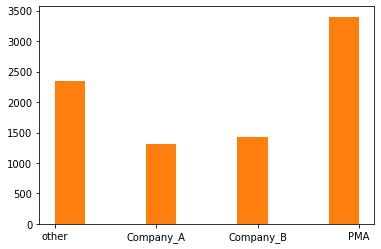

In [137]:
plt.hist(df_funnel['collnaam'])
plt.show()

There don't seem to be any strange values

### statusOms

In [122]:
df_funnel['statusOms'].isnull().sum(axis = 0)

2

In [126]:
df_funnel['statusOms'].unique()

array(['Nieuwe premieberekening', 'Polis opgemaakt',
       'Onvolledige aanvraag', 'Aanvraag ingetrokken',
       'Persoonlijk aanbod', 'Aanvraag afgewezen',
       'Maatwerk voorstel afgewezen', 'Maatwerk voorstel ingetrokken',
       'Persoonlijk aanbod afgewezen',
       'Wacht op terugkoppeling backoffice', 'Aanvraag geaccepteerd',
       'Maatwerk offerte aangevraagd', nan, 'Wacht op acceptatie',
       'Gewijzigd voorstel afgewezen'], dtype=object)

In [134]:
df_funnel[df_funnel[['statusOms']].isna().any(axis=1)]

,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on
3022,PMA,NaN,1660,NaN,11899,3025,1971-07-01,AUDI,2019-06-08,NaT,NaT,627.24,2013.0,December,NaN,J,NaN,2019-06-08
7385,PMA,NaN,3241,NaN,11447,3774,1998-04-01,JEEP,2019-06-18,NaT,NaT,1108.92,1992.0,November,J,NaN,NaN,2019-11-09


In [98]:
display(df_funnel['statusOms'].value_counts())

dict = {
    'Nieuwepremieberekening': 'Nieuwe premieberekening',
    'Onvolledigeaanvraag': 'Onvolledige aanvraag',
    'Polisopgemaakt': 'Polis opgemaakt',
    'Persoonlijkaanbod': 'Persoonlijk aanbod',
    'Wachtopterugkoppelingbackoffice': 'Wacht op terugkoppeling backoffice',
    'Maatwerkofferteaangevraagd': 'Maatwerk offerte aangevraagd',
    'Maatwerkvoorstelafgewezen': 'Maatwerk voorstel afgewezen',
    'Wachtopacceptatie': 'Wacht op acceptatie',
    'Aanvraaggeaccepteerd': 'Aanvraag geaccepteerd',
    'Aanvraagafgewezen': 'Aanvraag afgewezen',
    'Maatwerkvoorstelingetrokken': 'Maatwerk voorstel ingetrokken',
    'Aanvraagingetrokken': 'Aanvraag ingetrokken',
    'Persoonlijkaanbodafgewezen': 'Persoonlijk aanbod afgewezen',
    'Gewijzigdvoorstelafgewezen': 'Gewijzigd voorstel afgewezen'    
}

Nieuwe premieberekening               2881
Onvolledige aanvraag                  2732
Polis opgemaakt                       1694
Persoonlijk aanbod                     707
Wacht op terugkoppeling backoffice     386
Maatwerk offerte aangevraagd           206
Maatwerk voorstel afgewezen            191
Wacht op acceptatie                    167
Aanvraag geaccepteerd                  127
Aanvraag afgewezen                     102
Maatwerk voorstel ingetrokken           90
Aanvraag ingetrokken                    76
Persoonlijk aanbod afgewezen            11
Gewijzigd voorstel afgewezen             1
Name: statusOms, dtype: int64

There don't seem to be any strange values, but it would be clearer if they contain spaces. We'll replace them by the names with spaces

In [99]:
dict_repl = {
    'Nieuwepremieberekening': 'Nieuwe premieberekening',
    'Onvolledigeaanvraag': 'Onvolledige aanvraag',
    'Polisopgemaakt': 'Polis opgemaakt',
    'Persoonlijkaanbod': 'Persoonlijk aanbod',
    'Wachtopterugkoppelingbackoffice': 'Wacht op terugkoppeling backoffice',
    'Maatwerkofferteaangevraagd': 'Maatwerk offerte aangevraagd',
    'Maatwerkvoorstelafgewezen': 'Maatwerk voorstel afgewezen',
    'Wachtopacceptatie': 'Wacht op acceptatie',
    'Aanvraaggeaccepteerd': 'Aanvraag geaccepteerd',
    'Aanvraagafgewezen': 'Aanvraag afgewezen',
    'Maatwerkvoorstelingetrokken': 'Maatwerk voorstel ingetrokken',
    'Aanvraagingetrokken': 'Aanvraag ingetrokken',
    'Persoonlijkaanbodafgewezen': 'Persoonlijk aanbod afgewezen',
    'Gewijzigdvoorstelafgewezen': 'Gewijzigd voorstel afgewezen'    
}

df_funnel.replace(dict_repl, inplace=True)

In [140]:
print(df_funnel.dtypes)

collnaam                     object
statusOms                    object
offer_number                  int64
policy_number               float64
zipcode_link                  int64
zip4                          int64
birth_date           datetime64[ns]
brand                        object
datum_offer          datetime64[ns]
datum_request        datetime64[ns]
policy_start_date    datetime64[ns]
premium                     float64
buildyear_car               float64
buildmonth_car               object
wa                           object
wa_bep_ca                    object
wa_ca                        object
updated_on           datetime64[ns]
dtype: object


In [141]:
plt.hist(df_funnel['statusOms'].dropna())
plt.show()

ConversionError: Failed to convert value(s) to axis units: array(['Nieuwe premieberekening', 'Polis opgemaakt',
       'Onvolledige aanvraag', ..., 'Wacht op terugkoppeling backoffice',
       'Aanvraag afgewezen', 'Nieuwe premieberekening'], dtype=object)

### Offer Number

In [135]:
df_funnel[df_funnel[['offer_number']].isna().any(axis=1)]

,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on


No nan values

In [100]:
display(df_funnel['offer_number'].is_unique)


False

Normally these should be unique according to the data dictionary. Let's have a look at the duplicates

In [101]:
df_funnel['offer_number'].value_counts()

6255    5
4612    4
7708    4
8633    4
7670    4
       ..
4535    1
2492    1
6590    1
4543    1
2049    1
Name: offer_number, Length: 8444, dtype: int64

In [103]:
df_funnel[df_funnel.duplicated(subset='offer_number', keep=False)].sort_values(by=['offer_number'])

,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on
528,Company_A,Persoonlijk aanbod,1000,NaN,10266,2516,1966-12-01,FIAT,2018-12-19,NaT,NaT,172.32,2009.0,Mei,J,NaN,NaN,2018-12-27
0,Company_A,Aanvraag ingetrokken,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-11-10,2018-11-10,2018-01-11,686.04,2016.0,Juni,J,NaN,NaN,2018-11-10
901,Company_A,Polis opgemaakt,1634,10283.0,10556,6546,1992-10-01,CITROEN,2019-04-02,2019-05-02,2019-01-03,326.28,2009.0,Juli,NaN,J,NaN,2019-05-02
635,Company_B,Onvolledige aanvraag,1634,NaN,10432,1335,1990-04-01,SUZUKI,2019-01-01,NaT,NaT,362.64,2010.0,Juni,NaN,J,NaN,2019-01-01
1059,other,Polis opgemaakt,1636,10331.0,10640,6226,1962-09-01,TOYOTA,2019-02-26,2019-02-27,2019-01-03,346.73,2017.0,Mei,NaN,NaN,J,2019-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9211,PMA,Persoonlijk aanbod,9267,NaN,15471,2924,1989-08-01,PEUGEOT,2020-02-29,NaT,NaT,402.36,2004.0,September,J,NaN,NaN,2020-02-03
9149,PMA,Wacht op acceptatie,9276,11919.0,15479,2031,1965-01-01,VOLVO,2020-01-03,2020-01-03,2021-04-02,828.72,2011.0,Juli,NaN,NaN,J,2020-01-03
9212,PMA,Wacht op terugkoppeling backoffice,9276,11919.0,15479,2031,1965-01-01,VOLVO,2020-01-03,2020-01-03,2021-04-02,828.72,2011.0,Juli,NaN,NaN,J,2020-02-03
9213,PMA,Wacht op terugkoppeling backoffice,9280,11920.0,15481,3069,1987-01-01,MITSUBISHI,2020-01-03,2020-01-03,2020-02-04,1070.40,2015.0,Juli,NaN,NaN,J,2020-02-03


If their birthdate is the same, we'll chose to pick the one that has been updated the latest because then it probably is about the same person

In [104]:
df_funnel.sort_values('updated_on', inplace=True)
df_funnel.drop_duplicates(subset =['offer_number', 'birth_date'], keep = 'last', inplace=True) 

97     2018-01-11
99     2018-01-11
370    2018-01-12
372    2018-01-12
374    2018-01-12
          ...    
8361   2020-12-02
8363   2020-12-02
8367   2020-12-02
8311   2020-12-02
8393   2020-12-02
Name: updated_on, Length: 9373, dtype: datetime64[ns]

collnaam                     object
statusOms                    object
offer_number                  int64
policy_number               float64
zipcode_link                  int64
zip4                          int64
birth_date           datetime64[ns]
brand                        object
datum_offer          datetime64[ns]
datum_request        datetime64[ns]
policy_start_date    datetime64[ns]
premium                     float64
buildyear_car               float64
buildmonth_car               object
wa                           object
wa_bep_ca                    object
wa_ca                        object
updated_on           datetime64[ns]
dtype: object


In [107]:
df_funnel[df_funnel.duplicated(subset='offer_number', keep=False)].sort_values(by=['offer_number'])

,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on
0,Company_A,Aanvraag ingetrokken,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-11-10,2018-11-10,2018-01-11,686.04,2016.0,Juni,J,NaN,NaN,2018-11-10
528,Company_A,Persoonlijk aanbod,1000,NaN,10266,2516,1966-12-01,FIAT,2018-12-19,NaT,NaT,172.32,2009.0,Mei,J,NaN,NaN,2018-12-27
635,Company_B,Onvolledige aanvraag,1634,NaN,10432,1335,1990-04-01,SUZUKI,2019-01-01,NaT,NaT,362.64,2010.0,Juni,NaN,J,NaN,2019-01-01
901,Company_A,Polis opgemaakt,1634,10283.0,10556,6546,1992-10-01,CITROEN,2019-04-02,2019-05-02,2019-01-03,326.28,2009.0,Juli,NaN,J,NaN,2019-05-02
1059,other,Polis opgemaakt,1636,10331.0,10640,6226,1962-09-01,TOYOTA,2019-02-26,2019-02-27,2019-01-03,346.73,2017.0,Mei,NaN,NaN,J,2019-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7569,Company_B,Nieuwe premieberekening,7921,NaN,12182,3261,1995-09-01,MITSUBISHI,2020-01-01,NaT,NaT,0.00,2007.0,Augustus,NaN,J,NaN,2020-01-01
8374,other,Onvolledige aanvraag,8557,NaN,14960,3344,NaT,AUDI,2020-12-02,NaT,NaT,1473.84,2016.0,Juli,NaN,NaN,J,2020-02-13
8464,other,Nieuwe premieberekening,8557,NaN,14960,3344,1980-01-01,AUDI,2020-12-02,NaT,NaT,1473.84,2016.0,Juli,NaN,NaN,J,2020-02-17
8553,other,Nieuwe premieberekening,8697,NaN,12496,4251,NaT,VOLKSWAGEN,2020-02-21,NaT,NaT,867.48,2019.0,Juli,NaN,NaN,J,2020-02-21


WHAT TO DO WITH THESE 92 ROWS??? YOU CAN STILL REMOVE THE ONES WHERE ONE OF THE BIRTH DATES IS NaT

### Policy number

In [113]:
(df_funnel['policy_number'].value_counts()>1).value_counts()

False    1939
Name: policy_number, dtype: int64

### Zipcode link

In [116]:
df_funnel['zipcode_link'].groupby(by='zipcode_link')

KeyError: 'zipcode_link'

### Zip4

### Birth date

### Brand

In [120]:
df_funnel['brand'].unique()
df_funnel['brand'].isnull().sum(axis = 0)

3

In [117]:
df_funnel['brand'].value_counts()

VOLKSWAGEN    1011
OPEL           691
PEUGEOT        686
RENAULT        599
FORD           565
              ... 
BUICK            1
MASERATI         1
BENTLEY          1
SYM              1
MCLAREN          1
Name: brand, Length: 63, dtype: int64

In [114]:
print(df_funnel.columns)

Index(['collnaam', 'statusOms', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'datum_offer',
       'datum_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on'],
      dtype='object')


Besides the NaN values, there is no number that occurs twice, which makes sense

In [51]:
df_funnel['birth_date']=pd.to_datetime(df_funnel['birth_date'])
df_funnel['datum_offer']=pd.to_datetime(df_funnel['datum_offer'])
df_funnel['datum_request']=pd.to_datetime(df_funnel['datum_request'])
df_funnel['policy_start_date']=pd.to_datetime(df_funnel['policy_start_date'])
df_funnel['wa'].unique()
# df_funnel['buildyear_car']=df_funnel['buildyear_car'].astype(np.int64)

array(['J', 'N', nan], dtype=object)

In [56]:
(df_funnel['wa']!='J') & (df_funnel['wa_bep_ca']!='J') & (df_funnel['wa_ca']!='J')


0       False
1        True
2       False
3       False
4       False
        ...  
9368    False
9369    False
9370    False
9371    False
9372    False
Length: 9373, dtype: bool

In [63]:
df_funnel[((df_funnel['wa']=='J').astype(int) + (df_funnel['wa_bep_ca']=='J').astype(int) + (df_funnel['wa_ca']=='J') > 1)]

,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on
6421,Company_B,Persoonlijkaanbodafgewezen,7029,NaN,13972,8131,1966-05-01,PEUGEOT,2019-11-29,NaT,NaT,875.04,2003.0,Oktober,J,J,NaN,05-12-2019


In [42]:
df_funnel['policy_number'][df_funnel['policy_number']>0] = df_funnel['policy_number'][df_funnel['policy_number']>0].astype(int))

display(df_funnel)


SyntaxError: invalid syntax (<ipython-input-42-51fee64f83ac>, line 1)

In [17]:
df_claims.dtypes

policy_number          int64
claim_number           int64
claim_date            object
notification_date     object
finish_date           object
description           object
country_code          object
country               object
amount_cas           float64
amount_wa            float64
cost_ca              float64
cost_wa              float64
amount_reclaimed     float64
total                float64
dtype: object

In [18]:
df_claims['amount_wa'] = df_claims['amount_wa'].fillna(0)

display(df_claims)

,policy_number,claim_number,claim_date,notification_date,finish_date,description,country_code,country,amount_cas,amount_wa,cost_ca,cost_wa,amount_reclaimed,total
0,25065,10000,10-07-2015,19-10-2015,29-12-2015,"SCHULDSCHADE, NIET VERHAALBAAR",NL,Nederland,NaN,1748.20,NaN,NaN,NaN,1748.20
1,11948,10001,24-08-2015,25-08-2015,27-10-2015,"NIET SCHULDSCHADE, VERHAALBAAR",NL,Nederland,1549.83,0.00,40.29,NaN,-1448.58,141.54
2,11949,10002,04-01-2015,09-01-2015,03-03-2015,"NIET SCHULDSCHADE, VERHAALBAAR",NL,Nederland,405.48,0.00,40.29,NaN,-380.35,65.42
3,25066,10003,30-08-2015,01-12-2015,22-02-2016,HAGEL,NL,Nederland,130.20,0.00,77.44,NaN,-65.10,142.54
4,11950,10004,25-08-2014,01-09-2014,11-09-2014,RUITREPARATIE DOOR CARGLASS,NL,Nederland,83.99,0.00,1.00,NaN,NaN,84.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14804,27888,24804,05-03-2019,18-03-2019,13-05-2019,REED ACHTERUIT TEGEN STILSTAAND (ON)VERLICHT MTR,NL,Nederland,NaN,372.88,NaN,NaN,NaN,372.88
14805,25058,24805,11-10-2018,13-10-2018,16-10-2018,RUITREPARATIE DOOR AUTOTAALGLAS,NL,Nederland,60.50,0.00,NaN,NaN,NaN,60.50
14806,25060,24806,25-06-2019,27-06-2019,01-07-2019,RUITREPARATIE DOOR CARGLASS,NL,Nederland,72.60,0.00,NaN,NaN,NaN,72.60
14807,25061,24807,03-04-2018,03-04-2018,18-06-2018,REED TEGEN (ON)VERLICHT STILSTAAND OBJECT,NL,Nederland,NaN,2790.27,NaN,90.14,NaN,2880.41


In [19]:
for i in df_claims.columns:
    
    print(i, pd.unique(df_claims[i]))

policy_number [25065 11948 11949 ... 25060 25061 27889]
claim_number [10000 10001 10002 ... 24806 24807 24808]
claim_date ['10-07-2015' '24-08-2015' '04-01-2015' ... '11-10-2019' '08-09-2019'
 '22-01-2017']
notification_date ['19-10-2015' '25-08-2015' '09-01-2015' ... '29-08-2015' '04-08-2018'
 '13-10-2018']
finish_date ['29-12-2015' '27-10-2015' '03-03-2015' ... '29-04-2017' '10-02-2019'
 '15-04-2018']
description ['SCHULDSCHADE, NIET VERHAALBAAR' 'NIET SCHULDSCHADE, VERHAALBAAR' 'HAGEL'
 'RUITREPARATIE DOOR CARGLASS'
 'GEEN AFSTAND BEWAARD TOT VOORGANGER OP RECHTE WEG' 'ARTIKEL 185 WVW'
 'REED TEGEN STILSTAAND VAST OBJECT' 'Ruitvervanging door Glasgarage'
 'RUITBREUK' 'REED TEGEN (ON)VERLICHT STILSTAAND OBJECT'
 '(IN)BRAAK, DIEFSTAL, ACCESS, ETC.' 'STORM (CALAMITEIT)'
 'AUTODIEFSTAL ETC 2E PERIODE (NA 30 DGN)' 'RUITVERVANGING DOOR CARGLASS'
 'Ruitvervanging door ABS' 'VERLEENDE GEEN VOORRANG' 'SLOEG RECHTSAF'
 'STOND GEPARKEERD' 'Ruitvervanging door Schadenet'
 'REED ACHTERUIT OP REC

In [20]:
print(df_funnel.dtypes)
display(df_funnel)

collnaam              object
statusOms             object
offer_number           int64
policy_number        float64
zipcode_link           int64
zip4                   int64
birth_date            object
brand                 object
datum_offer           object
datum_request         object
policy_start_date     object
premium              float64
buildyear_car        float64
buildmonth_car        object
wa                    object
wa_bep_ca             object
wa_ca                 object
updated_on            object
dtype: object


,collnaam,statusOms,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,datum_offer,datum_request,policy_start_date,premium,buildyear_car,buildmonth_car,wa,wa_bep_ca,wa_ca,updated_on
0,Company_A,Aanvraagingetrokken,1000,10000.0,10000,2132,01-1985,HYUNDAI,11-10-2018,11-10-2018,01-11-2018,686.04,2016.0,Juni,J,NaN,NaN,11-10-2018
1,other,Maatwerkvoorstelingetrokken,1001,NaN,10001,6027,04-1987,AUDI,11-10-2018,NaN,NaN,0.00,2015.0,Juni,N,N,N,12-10-2018
2,other,Onvolledigeaanvraag,1002,NaN,10002,3824,11-1972,VOLKSWAGEN,11-10-2018,NaN,NaN,896.04,2016.0,April,NaN,NaN,J,11-10-2018
3,other,Polisopgemaakt,1003,10002.0,10003,6921,08-1983,MAZDA,11-10-2018,11-10-2018,12-10-2018,419.16,2009.0,Juni,NaN,J,NaN,11-10-2018
4,other,Polisopgemaakt,1004,10003.0,10004,8266,04-1990,VOLVO,12-10-2018,12-10-2018,01-11-2018,402.36,2003.0,Januari,J,NaN,NaN,12-10-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,other,Aanvraaggeaccepteerd,9439,11946.0,15568,1161,09-1960,VOLKSWAGEN,08-03-2020,08-03-2020,09-03-2020,510.68,2011.0,December,NaN,NaN,J,08-03-2020
9369,other,Wachtopacceptatie,9440,11947.0,15582,5015,04-1953,NISSAN,08-03-2020,08-03-2020,29-04-2020,459.60,2017.0,Februari,NaN,NaN,J,08-03-2020
9370,Company_A,Maatwerkofferteaangevraagd,9441,NaN,10332,3078,04-1976,TOYOTA,08-03-2020,NaN,NaN,521.16,2004.0,Januari,NaN,J,NaN,08-03-2020
9371,PMA,Nieuwepremieberekening,9442,NaN,12968,1965,07-1951,TOYOTA,08-03-2020,NaN,NaN,368.40,2004.0,September,NaN,J,NaN,08-03-2020
